## Google API code for calculating transit travel times

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import gmaps
gmaps.configure(api_key='API key')
import googlemaps
import pysal
import statsmodels.formula.api as smf
from datetime import datetime
import statsmodels.api as sm
from pyproj import Proj, transform
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


### Jobs data

In [2]:
dataJobs = gpd.read_file('data/nyc_lodes_zipcode_real/nyc_lodes_zipcode_real.shp')

In [3]:
dataJobs.head()

,ZIPCODE,2011_main,2011_total,2012_total,2015_total,2014_aux,2013_total,2012_aux,2013_main,2010_total,...,2014_total,2015_aux,2014_main,2015_per_m,rank,top,rank_notMN,top_notMN,CBDs,geometry
0,83.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,193.5,0,168.5,0,0,"POLYGON ((998309.7254775614 229616.6812362969,..."
1,10001.0,136551.944037,163014.429179,170271.223443,183574.208194,31120.034526,176595.914071,28958.421739,147100.025839,149992.497620,...,189201.340778,28734.888441,158081.306253,287591.963163,11.0,1,168.5,0,1,"POLYGON ((981958.6472873986 213464.4530421346,..."
2,10002.0,18241.376674,19750.748733,20205.790472,23303.050046,1921.498079,19033.545504,1630.603800,17311.940049,18817.103810,...,21019.026500,1863.979643,19097.528421,24719.910595,42.0,0,168.5,0,0,"POLYGON ((991339.8703228086 207576.7837151289,..."
3,10003.0,64739.789084,75048.649559,70059.871496,80194.913684,11508.768508,72793.737462,10273.453187,62081.330388,70894.659554,...,76009.878076,11036.073600,64501.109568,143880.788255,21.0,0,168.5,0,0,"POLYGON ((989830.469142139 207048.1263078749, ..."
4,10004.0,32686.421825,40692.918297,43504.289005,49802.929338,9156.631889,41669.002799,8663.048719,33490.618770,37856.752472,...,48395.422181,8774.706090,39238.790292,102423.421475,24.0,0,168.5,0,0,(POLYGON ((977542.4500830621 188447.2783390433...


### Central Business Districts (CBDs) defined as 1 and 2 in CBDs column

In [4]:
CBDs = dataJobs[['ZIPCODE', '2015_per_m', 'CBDs', 'geometry']]
CBDs.head()

,ZIPCODE,2015_per_m,CBDs,geometry
0,83.0,0.000000,0,"POLYGON ((998309.7254775614 229616.6812362969,..."
1,10001.0,287591.963163,1,"POLYGON ((981958.6472873986 213464.4530421346,..."
2,10002.0,24719.910595,0,"POLYGON ((991339.8703228086 207576.7837151289,..."
3,10003.0,143880.788255,0,"POLYGON ((989830.469142139 207048.1263078749, ..."
4,10004.0,102423.421475,0,(POLYGON ((977542.4500830621 188447.2783390433...


In [5]:
CBDs.describe()

,ZIPCODE,2015_per_m,CBDs
count,194.000000,1.940000e+02,194.000000
mean,10754.948454,6.502477e+04,0.154639
std,961.070963,2.259071e+05,0.428038
min,83.000000,0.000000e+00,0.000000
25%,10280.250000,3.674343e+03,0.000000
50%,11104.500000,8.420693e+03,0.000000
75%,11359.750000,1.813629e+04,0.000000
max,11697.000000,2.503324e+06,2.000000


### getting CBDs and plotting over zip codes map for visualization

In [6]:
toInclude = [1, 2]
CBDs = CBDs[(CBDs['CBDs'].isin(toInclude))]
CBDs.shape

(25, 4)

In [7]:
zips = gpd.read_file('data/ZIP_CODE_040114/ZIP_CODE_040114.shp')

In [8]:
zips['ZIPCODE'] = pd.to_numeric(zips['ZIPCODE'], errors='coerce')

Text(0.5,1,'CBDs in NYC')

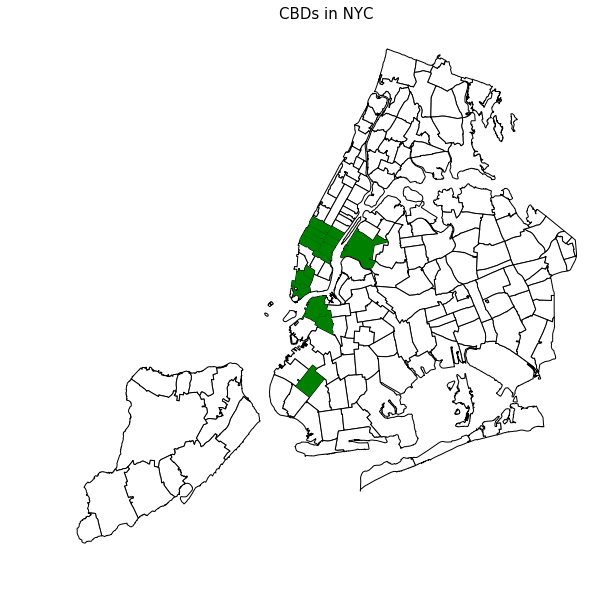

In [9]:
f, ax = plt.subplots(figsize=(10,10))
zips.plot(figsize=(8,8), ax=ax, color='white', edgecolor='black')
CBDs.plot(ax=ax, color='green')
ax.set_axis_off()
plt.title('CBDs in NYC', fontsize=15)

In [42]:
CBDs.head()

,ZIPCODE,2015_per_m,CBDs,geometry
1,10001.0,287591.963163,1,"POLYGON ((981958.6472873986 213464.4530421346,..."
5,10005.0,722069.638387,1,"POLYGON ((982595.6794779003 195880.7536295503,..."
6,10006.0,465524.379408,1,"POLYGON ((981136.3431577235 198082.3837407082,..."
7,10007.0,285129.560148,1,"POLYGON ((980538.9073447287 200658.5114624649,..."
9,10010.0,262415.242082,1,"POLYGON ((987500.0003778934 210146.4376965463,..."


### Reading file containing lat-long of centroids of all zip codes

In [10]:
zipsCentriods = pd.read_csv('data/zipLatLong.csv')
zipsCentriods.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [11]:
CBDs = CBDs.merge(zipsCentriods, left_on='ZIPCODE', right_on='ZIP', how='inner')
CBDs.head()

,ZIPCODE,2015_per_m,CBDs,geometry,ZIP,LAT,LNG
0,10001.0,287591.963163,1,"POLYGON ((981958.6472873986 213464.4530421346,...",10001,40.750633,-73.997177
1,10005.0,722069.638387,1,"POLYGON ((982595.6794779003 195880.7536295503,...",10005,40.706027,-74.008835
2,10006.0,465524.379408,1,"POLYGON ((981136.3431577235 198082.3837407082,...",10006,40.709614,-74.012954
3,10007.0,285129.560148,1,"POLYGON ((980538.9073447287 200658.5114624649,...",10007,40.713848,-74.007755
4,10010.0,262415.242082,1,"POLYGON ((987500.0003778934 210146.4376965463,...",10010,40.739065,-73.982255


In [12]:
zips = zips.merge(zipsCentriods, left_on='ZIPCODE', right_on='ZIP', how='inner')
zips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,ZIP,LAT,LNG
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,40.675807,-73.796622
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,40.671078,-73.936336
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,40.662936,-73.913029
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,40.663046,-73.954219
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,40.643468,-73.976046


In [13]:
zips = zips[['ZIPCODE', 'POPULATION', 'AREA', 'LAT', 'LNG', 'geometry']]
zips.head()

,ZIPCODE,POPULATION,AREA,LAT,LNG,geometry
0,11436,18681.0,2.269930e+07,40.675807,-73.796622,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,62426.0,2.963100e+07,40.671078,-73.936336,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,83866.0,4.197210e+07,40.662936,-73.913029,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,56527.0,2.369863e+07,40.663046,-73.954219,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,72280.0,3.686880e+07,40.643468,-73.976046,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [14]:
type(zips['ZIPCODE'].values[0])

numpy.int64

## Google API to calculate travel time from each zip to each CBD

In [ ]:
for zipcodes in CBDs['ZIP']:

    times = []
    distance = []
    for zipcode in zips['ZIPCODE']:
    
        
        originLat = zips.loc[zips.ZIPCODE == zipcode].LAT.values[0]
        originLng = zips.loc[zips.ZIPCODE == zipcode].LNG.values[0]
        #print originLat, originLng
        orig = [originLat, originLng]
        
        destLat = CBDs.loc[CBDs.ZIPCODE == zipcodes].LAT.values[0]
        destLng = CBDs.loc[CBDs.ZIPCODE == zipcodes].LNG.values[0]
        dest = [destLat, destLng]
        
        gmaps = googlemaps.Client(key='API key')


        now = datetime.now()
        directions_result = gmaps.directions(orig,
                                     dest,
                                     mode="transit",
                                     departure_time=now
                                    )

        #print directions_result
        if len(directions_result) != 0:
            dist = directions_result[0]['legs'][0]['distance']['value']
        
            time = int(directions_result[0]['legs'][0]['duration']['value'])/60
            times.append(time)
            distance.append(dist)
        else:
            times.append('None')
            distance.append('None')
    name = 'Timeto' + str(zipcodes)
    zips[name] = times

In [54]:
zips.tail()

,ZIPCODE,POPULATION,AREA,LAT,LNG,geometry,Timeto10001,Timeto10005,Timeto10006,Timeto10007,...,Timeto10038,Timeto10111,Timeto10112,Timeto10115,Timeto10282,Timeto11101,Timeto11109,Timeto11201,Timeto11217,Timeto11219
6,11219,92561.0,4.200274e+07,40.632667,-73.996669,"POLYGON ((987286.3515269756 173946.4621963799,...",49,26,33,31,...,32,44,41,60,38,52,50,21,20,0
7,11210,67067.0,4.788702e+07,40.628147,-73.946324,"POLYGON ((995796.0097044706 171110.0666224658,...",54,36,41,41,...,41,66,63,69,47,75,64,31,28,40
8,11230,80857.0,4.992670e+07,40.622164,-73.965105,"POLYGON ((994099.2959063053 171240.7064530551,...",54,39,45,44,...,43,57,53,72,50,64,62,34,29,33
9,11204,77354.0,4.355518e+07,40.618779,-73.984826,"POLYGON ((989500.1699339747 170730.1687602103,...",56,32,32,37,...,38,54,51,66,43,63,58,25,26,18
10,10471,23477.0,8.965141e+07,40.898868,-73.903328,"POLYGON ((1016890.088579223 269622.9437433034,...",66,75,77,69,...,78,65,61,47,78,75,83,81,87,107


In [125]:
type(zips)

geopandas.geodataframe.GeoDataFrame

Text(0.5,1,'Transit travel time to 10001 (Hudson Yards)')

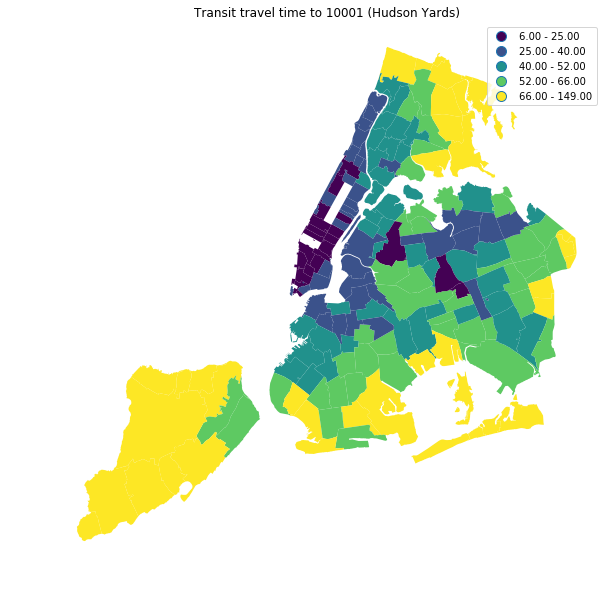

In [148]:
f, ax = plt.subplots(figsize=(10,10))
zips.plot(column='Timeto10001', figsize=(12,12), ax=ax, scheme='Quantiles', legend=True, cmap='viridis')
#CBDs.plot(ax=ax, color='green')
ax.set_axis_off()
plt.title('Transit travel time to 10001 (Hudson Yards)')

In [63]:
type(cbd['lng'].values[0])

numpy.float64

### Now calculating the travel times from each zip to every other zip

In [15]:
zipsDest = zips

In [98]:
count = 0
for zipcodes in zipsDest['ZIPCODE']:

    times = []
    distance = []
    for zipcode in zips['ZIPCODE']:
    
        
        originLat = zips.loc[zips.ZIPCODE == zipcode].Centroid_y.values[0]
        originLng = zips.loc[zips.ZIPCODE == zipcode].Centroid_x.values[0]
        #print originLat, originLng
        orig = [originLat, originLng]
        
        destLat = zipsDest.loc[zipsDest.ZIPCODE == zipcodes].Centroid_y.values[0]
        destLng = zipsDest.loc[zipsDest.ZIPCODE == zipcodes].Centroid_x.values[0]
        dest = [destLat, destLng]
       
        gmaps = googlemaps.Client(key='API key')
        


        now = datetime.now()
        directions_result = gmaps.directions(orig,
                                     dest,
                                     mode="transit",
                                     departure_time=now
                                    )

        #print directions_result
        if len(directions_result) != 0:
            dist = directions_result[0]['legs'][0]['distance']['value']
        
            time = (directions_result[0]['legs'][0]['duration']['value'])/60
            times.append(time)
            distance.append(dist)
        else:
            times.append('None')
            distance.append('None')
    name = 'Timeto' + str(zipcodes)
    zips[name] = times
    count = count+1
    print count

1
2
3
4
5
6
7
8
9
10


In [99]:
zips.head()

,ZIPCODE,Centroid_x,Centroid_y,Timeto11426.0,Timeto11427.0,Timeto11428.0,Timeto11429.0,Timeto11430.0,Timeto11432.0,Timeto11433.0,Timeto11434.0,Timeto11435.0,Timeto11436.0
1,10001.0,-73.996184,40.748783,70,63,48,54,68,51,47,61,30,48
2,10002.0,-73.986479,40.716059,89,83,70,73,93,58,67,76,54,77
3,10003.0,-73.988590,40.731671,80,70,65,69,86,54,65,80,54,75
4,10004.0,-74.012151,40.704069,87,70,66,69,89,63,74,64,61,83
5,10005.0,-74.008635,40.706135,87,63,59,62,87,62,73,50,41,82
